# EXO 2

In [1]:
import numpy as np
import pylab
import healpy as hp
import pysm3 
import pysm3.units as u
import matplotlib.pyplot as py
import cmbdb as cmb


In [2]:
from fgbuster.observation_helpers import get_instrument,get_observation,get_sky,get_noise_realization
from fgbuster.mixingmatrix import MixingMatrix

In [3]:
from fgbuster.component_model import CMB, Dust, Synchrotron
from fgbuster.separation_recipes import basic_comp_sep, harmonic_comp_sep

In [4]:
import fgbuster.algebra as alg

In [5]:
from fgbuster.separation_recipes import standardize_instrument, _intersect_mask,_get_prewhiten_factors,_A_evaluator,_get_alms,_format_alms,_r_to_c_alms


In [6]:
# a = u.uK_RJ.to(u.uk_CMB)
uK_RJ2uK_CMB = 1* u.uK_RJ.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(300.0 * u.GHz))
print(uK_RJ2uK_CMB)

6.983704969016967


In [7]:
def D_ell(C_ell):
    # Determine the length of the input power spectrum
    n_ell = len(C_ell)

    # Create an array of zeros to store the scale invariant power spectrum
    D_ell = np.zeros(n_ell)

    # Compute the scale invariant power spectrum using vectorized operations
    # Vectorized operations eliminate the need for a for loop, improving performance

    # Compute the product of each element with the next element using np.arange(n_ell) * (np.arange(n_ell) + 1)
    # Multiply the above result by C_ell to perform element-wise multiplication with the corresponding elements in C_ell
    # Divide the above result by np.pi to perform element-wise division by pi
    D_ell = np.arange(n_ell) * (np.arange(n_ell) + 1) * C_ell / np.pi

    # Return the computed scale invariant power spectrum
    return D_ell

In [8]:
def _mv(m, v):
    return np.einsum('...ij,...j->...i', m, v, optimize=False)

# Simulating Sky

In [9]:
nside_in = 128
lmax = 2*nside_in
print(lmax)
sky_d0s0 = get_sky(nside_in, 'd0s0') 
instrument = get_instrument('LiteBIRD')
freq_maps_d0s0 = get_observation(instrument,sky_d0s0)

num_freq,ncomp,npix = freq_maps_d0s0.shape


256


/home/julientang2001/fgbuster/fgbuster/observation_helpers.py:97: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  return df.dropna(1, 'all')


In [10]:
cl_CMB_th = hp.read_cl("/home/julientang2001/Stage3A/Cls_Planck2018_lensed_scalar.fits")
print(cl_CMB_th.shape)
cl_CMB_crop_th = cl_CMB_th[:,:lmax+1]
print(cl_CMB_crop_th.shape)
np.random.seed(0)
map_CMB = hp.synfast(cl_CMB_th,nside=nside_in,new = True)

cl_CMB6 = hp.anafast(map_CMB,lmax=lmax,alm = False)
cl_CMB = cl_CMB6[:4]
print(cl_CMB.shape)
map_CMB_QU = np.zeros((2,npix),dtype=complex)
map_CMB_QU[0] = map_CMB[1]  # Q
map_CMB_QU[1] = map_CMB[2]  # Q
print(map_CMB_QU.shape)

(4, 4001)
(4, 257)
(4, 257)
(2, 196608)


In [11]:
freq_maps_simple_noiseless = map_CMB+freq_maps_d0s0
np.random.seed(0)
freq_map_noise = get_noise_realization(nside=nside_in,instrument=instrument#,unit = 'uK_CMB'
                                       )
freq_maps_simple = freq_map_noise+freq_maps_simple_noiseless

print(freq_maps_simple.shape)
freq_maps_simple_QU = np.zeros((num_freq,2,npix))
for i in range(0,num_freq):
    freq_maps_simple_QU[i][0]=freq_maps_simple[i][1]   
    freq_maps_simple_QU[i][1]=freq_maps_simple[i][2]
print(freq_maps_simple_QU.shape)
amin2rad = np.pi/(60.*180.)

(15, 3, 196608)
(15, 2, 196608)


In [12]:
fwhm = instrument.fwhm*amin2rad
freq = instrument.frequency
print(instrument.fwhm)

0     70.5
1     58.5
2     51.1
3     47.1
4     43.8
5     41.5
6     37.8
7     33.6
8     30.8
9     28.9
10    28.6
11    24.7
12    22.5
13    20.9
14    17.9
Name: fwhm, dtype: float64


In [13]:

instrument_null = get_instrument('LiteBIRD')
instrument_null.fwhm = np.zeros(15)
print(instrument_null.fwhm)

0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
11    0.0
12    0.0
13    0.0
14    0.0
Name: fwhm, dtype: float64


/home/julientang2001/fgbuster/fgbuster/observation_helpers.py:97: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  return df.dropna(1, 'all')


In [14]:
beam_null = np.array([hp.gauss_beam(fwhm,lmax=lmax,pol=True) for fwhm in instrument_null.fwhm])

## Component separation

In [15]:
components = [CMB(), Dust(353.), Synchrotron(23.)]

In [16]:
# The starting point of the fit is the ax1sm default value, so let's shift it
components[1].defaults = [1.54, 20.]
components[2].defaults = [-3.0]

In [17]:
A = MixingMatrix(*components)
A_ev = A.evaluator(instrument.frequency)
i_cmb = A.components.index('CMB')

In [18]:
result_basic_noisy= basic_comp_sep(components, instrument, freq_maps_simple_QU, # verbose output                        
                       )
print(result_basic_noisy.s.shape)

A_basic_noise = A_ev(result_basic_noisy.x)

(3, 2, 196608)


In [19]:
print(A_basic_noise.shape)


(15, 3)


In [20]:
print(result_basic_noisy.x)

[ 1.54087229 19.96843719 -3.0025933 ]


In [21]:
alms = _get_alms(map_CMB, lmax=lmax)
num_lm = alms.shape[-1]
print(num_lm)

33153


In [22]:
def invN(instrument, window, num_lm, real=True):
    # Check if window is a NumPy array
    assert isinstance(window, np.ndarray), "Window must be a NumPy array"
    # Check if window has the last dimension equal to 4
    assert window.shape[-1] == 4, "Window last dimension must be 4"

    # Calculate the noise power spectrum
    nl = np.array([1 / (window[..., i] * np.radians(instrument.depth_p / 60.)[:, np.newaxis]) ** 2 for i in range(4)])

    # Get the ell values for the given number of lm modes
    ell = hp.Alm.getlm(lmax, np.arange(num_lm))[0]
    
    # Reshape ell for transformation into real alms if real=True
    if real:
        ell = np.stack((ell, ell), axis=-1).reshape(-1)

    num_stokes = nl.shape[0]
    invN_lm = nl[:, :, ell]

    # Create diagonal matrices from the invN_lm values
    invN_diag_lm = np.array([[np.diag(invN_lm[j, :, i]) for i in range(np.size(ell))] for j in range(num_stokes)])
    invN_diag_lm = np.transpose(invN_diag_lm, (1, 0, 2, 3))

    return invN_diag_lm


In [23]:
#Added by Clement Leloup
def harmonic_comp_sep(components, instrument, data, nside, lmax, invN=None,invNlm=None, mask=None, **minimize_kwargs):

    """ Harmonic component separation

    Parameters
    ----------
    components: list
        List storing the :class:`Component` s of the mixing matrix
    instrument:
        Object that provides the following as a key or an attribute.

        - **frequency**
        - **depth_i** or **depth_p** (optional, frequencies are inverse-noise
          weighted according to these noise levels)

        They can be anything that is convertible to a float numpy array.
    data: ndarray or MaskedArray
        Data vector to be separated. Shape *(n_freq, ..., n_pix).*
        *...* can be

        - absent or 1: temperature maps
        - 2: polarization maps
        - 3: temperature and polarization maps (see note)
    nside: int
        For each pixel of a HEALPix map with this nside, the non-linear
        parameters are estimated independently        
    lmax: int
        maximum multipole to use in the likelihood
    invN: ndarray
        estimated noise inverse covariance matrix. Shape *(n_freq, ..., n_lm)*
    mask: ndarray
        mask to be applied before going to harmonic domain, if any.

    Returns
    -------
    result: dict
        It includes

        - **param**: *(list)* - Names of the parameters fitted
        - **x**: *(ndarray)* - ``x[i]`` is the best-fit (map of) the *i*-th
          parameter
        - **Sigma**: *(ndarray)* - ``Sigma[i, j]`` is the (map of) the
          semi-analytic covariance between the *i*-th and the *j*-th parameter.
          It is meaningful only in the high signal-to-noise regime and when the
          *cov* is the true covariance of the data
        - **s**: *(ndarray)* - Component amplitude alms
        - **mask_good**: *(ndarray)* - mask of the entries actually used in the
          component separation

    Note
    ----

    * At the moment, only work with polarization (E AND B modes)

    """

    
    #instrument = standardize_instrument(instrument)
    #lmax = 3 * nside - 1
    n_comp = len(components)
    fsky = 1.0
    
    print('Computing alms')
    try:
        assert np.any(instrument.fwhm)
    except (KeyError, AssertionError):
        beams = None
    else:  # Deconvolve the beam
        beams = instrument.fwhm

    #alms_unmasked = _get_alms(data, beams, lmax=lmax)
    alms_unmasked = _get_alms(data, lmax=lmax)
    
    if mask is not None:
        data_masked = np.asarray([hp.alm2map(alms_unmasked[f], nside) for f in range(len(instrument.frequency))])
        data_masked *= mask
        fsky = float(mask.sum()) / mask.size
        alms = _get_alms(data_masked, lmax=lmax)[:,1:,:] # Here we take only polarization
    else:
        alms = alms_unmasked[:,1:,:] # Here we take only polarization
        
    cl_in = np.array([hp.alm2cl(alm) for alm in alms])
    ell = hp.Alm.getlm(lmax, np.arange(alms.shape[-1]))[0]
    ell = np.stack((ell, ell), axis=-1).reshape(-1) # For transformation into real alms
    #mask_lmin = [l < lmin for l in ell]

    if invNlm is None:
        if invN is not None:
            ell_em = hp.Alm.getlm(lmax, np.arange(alms.shape[-1]))[0]
            ell_em = np.stack((ell_em, ell_em), axis=-1).reshape(-1) # Because we use real alms
            invNlm = np.array([invN[l,1:,:,:] for l in ell_em]) # Here we take only polarization
        else:
            invNlm = None

    #Format alms to be used in comp sep
    alms = _format_alms(alms)

    
    A_ev, A_dB_ev, comp_of_param, x0, params = _A_evaluator(components, instrument)
    if not len(x0):
        A_ev = A_ev()

    # Component separation
    res = alg.comp_sep(A_ev, alms, invNlm, A_dB_ev, comp_of_param, x0, **minimize_kwargs)

    # Craft output
    # 1) Apply the mask, if any
    # 2) Restore the ordering of the input data (pixel dimension last)
    res.params = params
    res.s = np.swapaxes(res.s, 0, 2)
    res.s[res.s == hp.UNSEEN] = 0.
    #res.s = np.asarray(res.s, order='C').view(np.complex128)
    res.s = _r_to_c_alms(res.s)
    cl_out = np.array([hp.alm2cl(alm) for alm in res.s])
    res.cl_in = cl_in/fsky
    res.cl_out = cl_out/fsky
    res.fsky = fsky
    res.chi = res.chi.T
    if 'chi_dB' in res:
        for i in range(len(res.chi_dB)):
            res.chi_dB[i] = res.chi_dB[i].T
    if nside and len(x0):
        res.x = res.x.T
        res.Sigma = res.Sigma.T

    return res


In [24]:
invN_litebird =  invN(instrument_null,window=beam_null,num_lm=num_lm, real = True)


/var/tmp/pbs.180654.idark/ipykernel_249635/1226510151.py:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  nl = np.array([1 / (window[..., i] * np.radians(instrument.depth_p / 60.)[:, np.newaxis]) ** 2 for i in range(4)])


In [25]:
print(invN_litebird.shape)

(66306, 4, 15, 15)


In [26]:
result_harmonic_noisy = harmonic_comp_sep(components, instrument, freq_maps_simple,nside=nside_in,lmax=lmax,invNlm=invN_litebird[:,1:3,:,:] # verbose output             
                               )
A_harmonic_noise = A_ev(result_harmonic_noisy.x)

print(A_harmonic_noise.shape)

Computing alms


/home/julientang2001/fgbuster/fgbuster/mixingmatrix.py:187: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  res += [g[..., np.newaxis]
/home/julientang2001/fgbuster/fgbuster/algebra.py:1079: RuntimeWarning: invalid value encountered in divide
  res.chi_dB.append(np.sum(res.chi * As_dB_i, -1)


(15, 3)


In [27]:
print(result_harmonic_noisy.x)
print(result_basic_noisy.x)

[ 1.54087424 19.96828634 -3.00252447]
[ 1.54087229 19.96843719 -3.0025933 ]


### Compute noise after component separation

In [28]:
def _get_Cl_noise_nofwhm(instrument, A, lmax):
    bl = np.ones((len(instrument.frequency), lmax+1))
    nl = (bl / np.radians(instrument.depth_p/60.)[:, np.newaxis])**2
    AtNA = np.einsum('fi, fl, fj -> lij', A, nl, A)
    inv_AtNA = np.linalg.inv(AtNA)
    return inv_AtNA.swapaxes(-3, -1)

In [29]:
cl_basic_noise =_get_Cl_noise_nofwhm(instrument=instrument,A = A_basic_noise,lmax=lmax)[i_cmb, i_cmb, :]
cl_harmonic_noise =_get_Cl_noise_nofwhm(instrument=instrument,A = A_harmonic_noise,lmax=lmax)[i_cmb, i_cmb, :]
print(cl_basic_noise.shape)


(257,)


/var/tmp/pbs.180654.idark/ipykernel_249635/3811725195.py:3: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  nl = (bl / np.radians(instrument.depth_p/60.)[:, np.newaxis])**2


In [30]:
inputs = [sky_d0s0.components[0].mbb_index,
          sky_d0s0.components[0].mbb_temperature.value,
          sky_d0s0.components[1].pl_index]

for param, val, ref in zip(result_basic_noisy.params, result_basic_noisy.x, inputs):
    print("%-20s\t%f\t%f" % (param, val, ref))

print("%-20s\t%s\t%s" % ('', 'Estimated', 'Input'))
for param, val, ref in zip(result_harmonic_noisy.params, result_harmonic_noisy.x, inputs):
    print("%-20s\t%f\t%f" % (param, val, ref))

Dust.beta_d         	1.540872	1.540000
Dust.temp           	19.968437	20.000000
Synchrotron.beta_pl 	-3.002593	-3.000000
                    	Estimated	Input
Dust.beta_d         	1.540874	1.540000
Dust.temp           	19.968286	20.000000
Synchrotron.beta_pl 	-3.002524	-3.000000


In [31]:
print(result_basic_noisy.s.shape)

(3, 2, 196608)


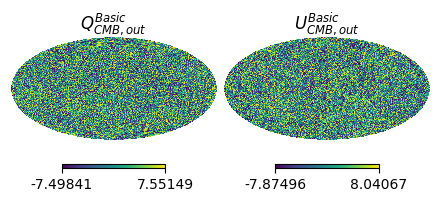

In [32]:
# hp.mollview(result_basic_noisy.s[0,0], title='$Q_{CMB,out}^{basic}$', norm='hist', sub=(1,3,2))
# hp.mollview(result_basic_noisy.s[0,1], title='$U_{CMB,out}^{basic}$', norm='hist', sub=(1,3,3))
hp.mollview(result_basic_noisy.s[0,0], title='$Q_{CMB,out}^{Basic}$', norm='hist', sub=(1,3,2))
hp.mollview(result_basic_noisy.s[0,1], title='$U_{CMB,out}^{Basic}$', norm='hist', sub=(1,3,3))

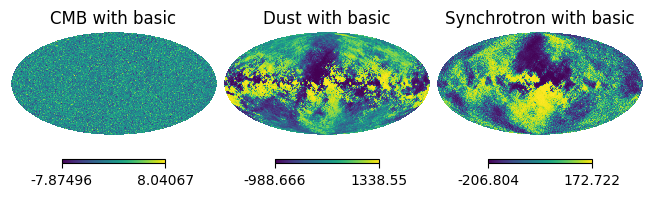

In [33]:
hp.mollview(result_basic_noisy.s[0,1], title='CMB with basic', sub=(1,3,1))
hp.mollview(result_basic_noisy.s[1,1], title='Dust with basic', norm='hist', sub=(1,3,2))
hp.mollview(result_basic_noisy.s[2,1], title='Synchrotron with basic', norm='hist', sub=(1,3,3))
# hp.mollview(result_harmonic_noisy.s[0,1], title='CMB without basic', sub=(1,3,1))
# hp.mollview(result_harmonic_noisy.s[1,1], title='Dust without basic', norm='hist', sub=(1,3,2))
# hp.mollview(result_harmonic_noisy.s[2,1], title='Synchrotron without basic', norm='hist', sub=(1,3,3))

In [34]:
def invN_l(instrument, window, lmax, real=True):
    # Check if window is a NumPy array
    assert isinstance(window, np.ndarray), "Window must be a NumPy array"
    # Check if window has the last dimension equal to 4
    assert window.shape[-1] == 4, "Window last dimension must be 4"

    # Calculate the noise power spectrum
    nl = np.array([1 / (window[..., i] * np.radians(instrument.depth_p / 60.)[:, np.newaxis]) ** 2 for i in range(4)])

    # Get the ell values 
    ell = np.arange(lmax+1)

    invN_lm = nl[:,:,ell]
    invN_diag_lm = np.array([[np.diag(invN_lm[j,:,i]) for i in range(0,np.size(ell))]for j in range(0,3)])
    invN_diag_lm = np.transpose(invN_diag_lm, (1, 0, 2, 3))
    return (invN_diag_lm)


In [35]:
W_mat_harmo = alg.W(A_ev(result_harmonic_noisy.x),invN=invN_l(instrument_null,window=beam_null,lmax=lmax))

/var/tmp/pbs.180654.idark/ipykernel_249635/1423314690.py:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  nl = np.array([1 / (window[..., i] * np.radians(instrument.depth_p / 60.)[:, np.newaxis]) ** 2 for i in range(4)])


In [36]:
W_mat_basic = alg.W(A_ev(result_basic_noisy.x),invN=invN_l(instrument_null,window=beam_null,lmax=lmax))

/var/tmp/pbs.180654.idark/ipykernel_249635/1423314690.py:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  nl = np.array([1 / (window[..., i] * np.radians(instrument.depth_p / 60.)[:, np.newaxis]) ** 2 for i in range(4)])


In [37]:
ell_tot = hp.Alm.getlm(lmax, np.arange(num_lm))[0]
Wlm_harmo = W_mat_harmo[ell_tot,:,:,:]


Wlm_harmo = Wlm_harmo[:,1:3,:,:]


In [38]:

noise_alm = np.array([hp.map2alm(map_noise,lmax=lmax) for map_noise in freq_map_noise])
noise_alm_EB = noise_alm[:,1:3,:]
noise_alm_EB = noise_alm_EB.transpose()

In [39]:
print(Wlm_harmo.shape)
print(noise_alm_EB.shape)

(33153, 2, 3, 15)
(33153, 2, 15)


In [40]:
noise_alm_eff_harmo = _mv(Wlm_harmo,noise_alm_EB)
print(noise_alm_eff_harmo.shape)
noise_alm_eff_harmo = noise_alm_eff_harmo.swapaxes(0,2)
print(noise_alm_eff_harmo.shape)

(33153, 2, 3)
(3, 2, 33153)


In [41]:
Wlm_basic= W_mat_basic[ell_tot,:,:,:]
print(Wlm_basic.shape)

(33153, 3, 3, 15)


In [42]:
noise_alm2 = noise_alm.transpose()

In [43]:
print(noise_alm2.shape)
print(Wlm_basic.shape)

(33153, 3, 15)
(33153, 3, 3, 15)


In [44]:
noise_alm_eff_basic = _mv(Wlm_basic,noise_alm2)
print(noise_alm_eff_basic.shape)
noise_alm_eff_basic = noise_alm_eff_basic.swapaxes(0,2)
print(noise_alm_eff_basic.shape)

(33153, 3, 3)
(3, 3, 33153)


In [45]:
noise_CMB_map = hp.alm2map(np.ascontiguousarray(noise_alm_eff_basic[0]),nside=nside_in,lmax=lmax)

In [46]:
print(noise_CMB_map.shape)

(3, 196608)


# Residuals

In [47]:
alm_CMB = hp.map2alm(map_CMB,lmax=lmax,iter=10)

In [48]:
print(alm_CMB.shape)
print(result_harmonic_noisy.s.shape)

(3, 33153)
(3, 2, 33153)


In [49]:
res_CMB_harmonic = result_harmonic_noisy.s[0]-alm_CMB[1:3]-noise_alm_eff_harmo[0]
print(res_CMB_harmonic.shape)

(2, 33153)


In [50]:
np.save('Beamless_resi',res_CMB_harmonic)

In [51]:
res_CMB_basic = np.zeros((3,npix),dtype=complex)
res_CMB_basic[1:3] = result_basic_noisy.s[0,0:2]- map_CMB_QU[0:2]-noise_CMB_map[1:3]
print(res_CMB_basic.shape)

(3, 196608)


In [52]:
C_l_CMB_basic =hp.anafast(res_CMB_basic,lmax = lmax,alm=False,pol=True)
C_l_CMB_harmonic =hp.alm2cl(res_CMB_harmonic,lmax=lmax)
print(C_l_CMB_basic.shape)

(6, 257)


/home/julientang2001/.conda/envs/FGBuster_JT/lib/python3.11/site-packages/healpy/sphtfunc.py:274: ComplexWarning: Casting complex values to real discards the imaginary part
  alms = _sphtools.map2alm(


In [53]:
C_EE_CMB_basic_l = C_l_CMB_basic[1]
C_BB_CMB_basic_l = C_l_CMB_basic[2]

print(C_EE_CMB_basic_l.shape)
print(C_BB_CMB_basic_l.shape)

(257,)
(257,)


In [54]:
print(C_l_CMB_harmonic.shape)

(3, 257)


In [55]:
C_EE_CMB_harmonic_l = C_l_CMB_harmonic[0]
C_BB_CMB_harmonic_l = C_l_CMB_harmonic[1]

In [56]:
np.save('Beamless_resi',C_BB_CMB_harmonic_l)

### Retrieved CMB Power spectrum

In [57]:
res_ret_basic = np.zeros((3,npix),dtype=complex)
res_ret_basic[1:3] = result_basic_noisy.s[0,0:2]
print(res_ret_basic.shape)
res_ret_harmonic = result_harmonic_noisy.s[0,0:2]
print(res_ret_harmonic.shape)

(3, 196608)
(2, 33153)


In [58]:
C_L_ret_basic = hp.anafast(res_ret_basic,lmax=lmax,alm = False,pol=True)
print(C_L_ret_basic.shape)
C_l_ret_basic_BB = C_L_ret_basic[2]
print(C_l_ret_basic_BB.shape)

(6, 257)
(257,)


In [59]:
C_L_ret_harmonic = hp.alm2cl(res_ret_harmonic,lmax=lmax)
print(C_L_ret_harmonic.shape)
C_l_ret_harmonic_BB = C_L_ret_harmonic[1]
print(C_l_ret_harmonic_BB.shape)

(3, 257)
(257,)


# + Gravitational waves

In [60]:
cl_GW = hp.read_cl("/home/julientang2001/Stage3A/Cls_Planck2018_unlensed_scalar_and_tensor_r1.fits")
print(cl_GW.shape)
cl_GW_crop = cl_GW[:,:lmax+1]
print(cl_GW_crop.shape)

map_CMB = hp.synfast(cl_GW,nside=nside_in)

(4, 4101)
(4, 257)


In [61]:
cl_tot_th = np.add(0.001*cl_GW_crop,cl_CMB)

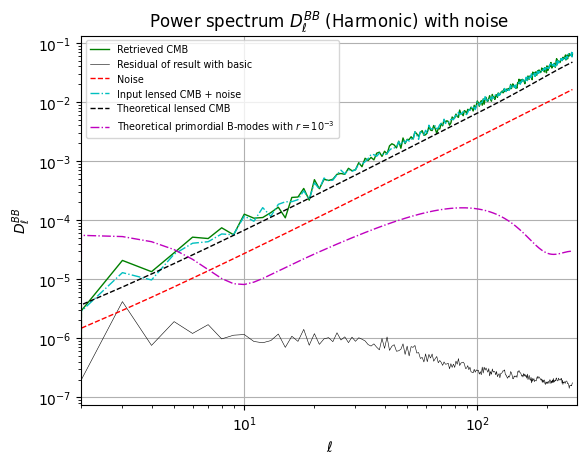

In [72]:
# py.figure(1)

l_arr = np.arange(0,lmax+1,1)
# ax1 = py.subplot(211)

# ax1.plot(l_arr,l_arr*(l_arr+1)/np.pi*C_EE_CMB_basic_l,'r',label = 'with basic')
# ax1.plot(l_arr,l_arr*(l_arr+1)/np.pi*C_EE_CMB_harmonic_l,'b',label = 'without basic')
# ax1.plot(l_arr,l_arr*(l_arr+1)/np.pi*cl_CMB[1],label = "$D_{\ell,lens}^{EE}$")
# ax1.plot(l_arr,l_arr*(l_arr+1)/np.pi*0.001*cl_GW_crop[1],label = "$D_{\ell,GW}^{EE}$")

# handles, labels = ax1.get_legend_handles_labels()
# #py.legend(handles, labels)

# py.grid()
# py.tick_params('x', labelbottom=False)
# py.ylabel('$D_{\ell}^{EE}$')
# py.yscale("log")
# py.xscale("log")

# py.title('Power spectra of the residuals $D_{\ell}^{BB}$ of the residuals with and without basic')

# py = py.subplot(212,sharex = ax1)
py.figure(1)
ax1 = py.subplot(111)
# ax1.tick_params('x', labelsize=6)

ax1.plot(l_arr,D_ell(C_l_ret_harmonic_BB),'g',linewidth = 1,label = 'Retrieved CMB')
ax1.plot(l_arr,D_ell(C_BB_CMB_basic_l),'k',linewidth =.4,label = 'Residual of result with basic')
ax1.plot(l_arr,D_ell(cl_basic_noise),'r--',linewidth =1, label = 'Noise')
ax1.plot(l_arr,D_ell(cl_CMB[2]+cl_basic_noise),'c-.',linewidth =1,label = "Input lensed CMB + noise")
py.title('Power spectrum $D_{\ell}^{BB}$ (with basic) with noise')

#ax1.plot(l_arr,D_ell(C_l_ret_harmonic_BB),'g',linewidth = 1,label = 'Retrieved CMB')
#ax1.plot(l_arr,D_ell(C_BB_CMB_harmonic_l),'g--',linewidth =.4,label = 'Residual of harmonic result')
#ax1.plot(l_arr,D_ell(cl_harmonic_noise),'r',linewidth =1, label = 'Noise')
#ax1.plot(l_arr,D_ell(cl_CMB[2]+cl_harmonic_noise),'k-.',linewidth =.4,label = "Input lensed CMB + noise")

py.title('Power spectrum $D_{\ell}^{BB}$ (Harmonic) with noise')
         #of the residuals with and without basic, with noise')

ax1.plot(l_arr,l_arr*(l_arr+1)/np.pi*np.add(cl_CMB_crop_th[2],0),'k--',linewidth =1,label = "Theoretical lensed CMB ")

        #  $D_{\ell,lens}^{BB}$")
ax1.plot(l_arr,l_arr*(l_arr+1)/np.pi*0.001*cl_GW_crop[2],'m-.',linewidth =1,label = "Theoretical primordial B-modes with $r=10^{-3}$")
        # $D_{\ell,GW}^{BB}$")

handles, labels = ax1.get_legend_handles_labels()
py.xlim(left = 2)
py.grid()
py.xlabel('$\ell$')
py.yscale("log")
py.xscale("log")



py.ylabel('$D_{\ell}^{BB}$')
py.legend(handles,labels, loc = 'upper left', fontsize = 'x-small')
py.show()

In [63]:
rapport = cl_CMB[2]/cl_CMB_crop_th[2]
print(rapport.shape)
rapport = rapport[2:]
print(np.sum(rapport)/len(rapport))

(257,)
0.9889955560012749


/var/tmp/pbs.180654.idark/ipykernel_249635/362470105.py:1: RuntimeWarning: invalid value encountered in divide
  rapport = cl_CMB[2]/cl_CMB_crop_th[2]


# Cosmological likelihood

In [64]:
r_arr = np.logspace(-6,-2,100)


In [65]:
C_l_test =0.001*cl_GW_crop[2,:lmax+1]+cl_CMB_crop_th[2,:lmax+1] + cl_basic_noise

In [66]:
def cosmo_likelihood(r, C_l_obs, noise):
    lmax = len(C_l_obs) - 1
    
    if len(C_l_obs) != lmax + 1 or len(noise) != lmax + 1:
        raise Warning("Arrays should be of size " + str(lmax))
    
    C_lth = r * cl_GW_crop[2,:lmax+1] + cl_CMB_crop_th[2,:lmax+1] + noise
    
    l_values = np.arange(2, lmax)
    sig = np.sum(((2*l_values+1)*(np.log(C_lth[l_values])+C_l_obs[l_values]/C_lth[l_values])-(2*l_values-1)*np.log(C_l_obs[l_values]))/(-2.))
    
    return -sig

In [67]:
y_test = np.array([cosmo_likelihood(r, C_l_obs=C_l_test, noise=cl_basic_noise) for r in r_arr])

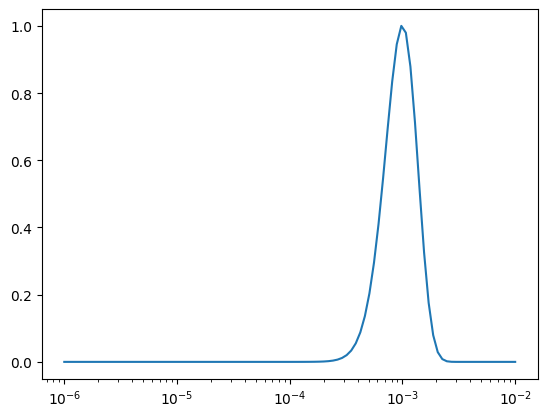

In [68]:
py.plot(r_arr,np.exp((np.min(y_test)-y_test)/2))
py.xscale('log')
py.show()

29623.06991535255
29623.058359745475
inv : 29623.056007648167
ren : 29623.06745808256
[29623.05600765 29623.05579691 29623.05556939 29623.0553242
 29623.05506054 29623.05477768 29623.05447506 29623.05415232
 29623.05380936 29623.05344645 29623.05306432 29623.05266428
 29623.0522484  29623.05181969 29623.0513823  29623.05094185
 29623.0505057  29623.05008338 29623.04968705 29623.04933202
 29623.04903746 29623.04882713 29623.04873029 29623.04878276
 29623.04902815 29623.04951931 29623.05031992 29623.05150644
 29623.05317026 29623.05542016 29623.05838509 29623.06221734
 29623.06709603 29623.07323104 29623.08086731 29623.09028955
 29623.10182745 29623.11586118 29623.13282738 29623.15322549
 29623.17762439 29623.20666939 29623.24108943 29623.28170446
 29623.32943295 29623.38529949 29623.45044247 29623.52612166
 29623.61372597 29623.71478118 29623.83095791 29623.96408002
 29624.11613359 29624.28927697 29624.48585237 29624.70839955
 29624.9596724  29625.24265933 29625.56060844 29625.91705876


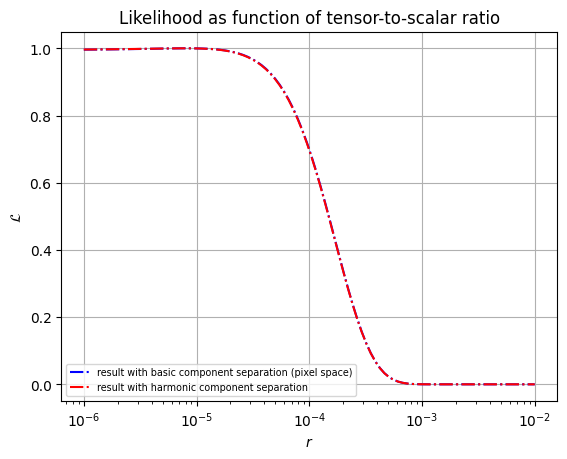

In [69]:
avg_cosmo_basic= cosmo_likelihood(r=0,C_l_obs=C_l_ret_basic_BB,noise=cl_basic_noise)
avg_cosmo_harmonic = cosmo_likelihood(r=0,C_l_obs=C_l_ret_harmonic_BB,noise=cl_harmonic_noise)

print(avg_cosmo_basic)
print(avg_cosmo_harmonic)
y_basic =np.array([cosmo_likelihood(r,C_l_obs=C_l_ret_basic_BB,noise=cl_basic_noise) for r in r_arr])
y_harmonic =np.array([cosmo_likelihood(r,C_l_obs=C_l_ret_harmonic_BB,noise=cl_harmonic_noise) for r in r_arr])
# y_basic[0] = avg_cosmo_basic
# y_harmonic[0] = avg_cosmo_harmonic

# y_harmonic[0] = np.min(y_harmonic)
# y_basic[0] = np.min(y_basic)
print('inv : '+str(y_harmonic[0]))
print('ren : '+str(y_basic[0]))
print(y_harmonic)
fig,ax = py.subplots()

ax.plot(r_arr,np.exp((np.min(y_basic)-y_basic)/2),'b-.', label = 'result with basic component separation (pixel space)')
ax.plot(r_arr,np.exp((np.min(y_harmonic)-y_harmonic)/2),'r-.',label = 'result with harmonic component separation')




# ax.plot(r_arr,-y_basic)
# ax.plot(r_arr,-y_harmonic)

py.title('Likelihood as function of tensor-to-scalar ratio')
handles, labels = ax.get_legend_handles_labels()
py.xlabel(r'$r$')
py.ylabel(r'$\mathcal{L}$')

# py.ylabel(r'$e^{-1+\frac{\langle ln \mathcal{L}_{par} \rangle}{\langle ln \mathcal{L}_{par}(r=0) \rangle}}$')
# py.yscale("log")
py.xscale("log")
# py.xlim(0,1e-3)
py.grid()
# py.ylim(-1,1)

        #  of the residuals with and without beam, with noise')
# Set the background color of the plot
# ax.set_facecolor('gray')

# Set the background color of the figure
# ax.xaxis.label.set_color('white')
# ax.yaxis.label.set_color('white')
# ax.title.set_color('white')
# fig.set_facecolor('gray')

py.legend(handles,labels, loc = 'best', fontsize = 'x-small')
py.savefig('Beamless case likelihood')
py.show()

In [70]:
likelihood_beamless = np.exp((np.min(y_harmonic)-y_harmonic)/2)

In [71]:
np.save('Likelihood_beamless',likelihood_beamless)